In [2]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import seaborn as sns

In [24]:
class Data:
    def __init__(self, train_path, test_path, seq_length):
        self.train_df = pd.read_csv(train_path)
        self.test_df = pd.read_csv(test_path)
        self.seq_length = seq_length

    def data_scaling(self):
        train_df = self.train_df
        test_df = self.test_df

        train_n, _ = train_df.shape
        test_n, _ = test_df.shape

        df_all = pd.concat([train_df, test_df], ignore_index=True)

        scaler_x = MinMaxScaler()
        scaler_x.fit(df_all.iloc[:, 2:7])
        df_all.iloc[:, 2:7] = scaler_x.transform(df_all.iloc[:, 2:7])

        scaler_y = MinMaxScaler()
        scaler_y.fit(df_all.iloc[:, [1]])
        df_all.iloc[:, [1]] = scaler_y.transform(df_all.iloc[:, [1]])

        imputer = SimpleImputer()
        train_imputer = imputer.fit(df_all.iloc[:train_n, 1:7])
        test_imputer = imputer.fit(df_all.iloc[:-test_n, 1:7])

        train_df = train_imputer.transform(df_all.iloc[:train_n, 1:7])
        test_df = test_imputer.transform(df_all.iloc[:-test_n, 1:7])

        return train_df, test_df, scaler_x, scaler_y

    def build_dataset(self, data, seq_length, is_test=False):
        X = []
        Y = []
        if is_test:
            length = 365 + seq_length - 1
        else:
            length = len(data)
        for i in range(0, length - seq_length):
            _x = data[i:i+seq_length, 1:]
            _y = data[i+seq_length, [0]]
            X.append(_x)
            Y.append(_y)
        return np.array(X), np.array(Y)

    def get_dataset(self):
        scaled_train_df, scaled_test_df, scaler_x, scaler_y = self.data_scaling()
        train_X, train_y = self.build_dataset(scaled_train_df, self.seq_length, is_test=False)
        test_X, test_y = self.build_dataset(scaled_test_df, self.seq_length, is_test=True)
        return train_X, train_y, test_X, test_y, scaler_x, scaler_y

In [38]:
def nse_metric(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    mse = np.mean((y_true - y_pred) ** 2)
    nse = 1 - mse / np.var(y_true)
    return nse

def rmse_metric(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def buffer_accuracy(y_true, y_pred, buffer):
    assert y_true.shape == y_pred.shape
    within_buffer = np.abs(y_true - y_pred) <= buffer
    accuracy = np.mean(within_buffer)
    return accuracy

def calculate_buffer(y_true, alpha=1):
    std_dev = np.std(y_true)
    buffer = alpha * std_dev
    return buffer

def main(look_back, epochs, show=False):
    train_path = 'h_test/train/haeng17-21.csv'
    test_path = 'h_test/test/haeng22.csv'

    Haeng_dataset = Data(train_path, test_path, look_back)
    train_X, train_y, test_X, test_y, scaler_x, scaler_y = Haeng_dataset.get_dataset()

    input_size = train_X.shape[2]
    hidden_size = 10

    # LSTM 모델 생성
    model = Sequential()
    model.add(LSTM(hidden_size, input_shape=(look_back, input_size)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(train_X, train_y, epochs=epochs, batch_size=32, verbose=1)

    # 모델 테스트
    testPredict = model.predict(test_X)

    # 역정규화
    testPredict = scaler_y.inverse_transform(testPredict)
    test_y_inv = scaler_y.inverse_transform(test_y)

    mse = mean_squared_error(test_y_inv, testPredict)
    nse = nse_metric(test_y_inv, testPredict)
    rmse = rmse_metric(test_y_inv, testPredict)

    buffer = calculate_buffer(test_y_inv, alpha=1)
    accuracy = buffer_accuracy(test_y_inv, testPredict, buffer)

    print('Test MSE: %.3f' % mse)
    print(f"NSE: {nse}")
    print(f"RMSE: {rmse}")
    print(f"Buffer Accuracy: {accuracy * 100}% - Buffer: {buffer}")

    # Time data for x-axis
    time_data = pd.date_range(start='2022-01-01', periods=len(test_y_inv), freq='D')
    # 예측 결과와 실제 값 비교를 위한 그래프 생성
    plt.figure(figsize=(12, 6))
    plt.plot(time_data, test_y_inv, label='actual')
    plt.plot(time_data, testPredict, label='prediction')
    plt.xlabel('Time')
    plt.ylabel('River Level')
    plt.legend()
    plt.show()

    if show:
        # 예측 결과와 실제 값 비교를 위한 그래프 생성
        plt.figure(figsize=(12, 6))
        plt.scatter(test_y_inv, testPredict, alpha=0.5)
        plt.xlabel('Actual')
        plt.ylabel('Prediction')
        plt.title('Scatter Plot: Actual vs Prediction')
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.heatmap(testPredict, cmap='YlGnBu')
        plt.xlabel('Day')
        plt.ylabel('Sample')
        plt.title('Heatmap: Predicted Values')
        plt.show()

        # 예측 결과와 실제 값 비교를 위한 그래프 생성
        plt.figure(figsize=(12, 6))
        feature_names = ['flux', 'precipitation', 'temperature', 'humid', 'heat']
        for i in range(test_X.shape[2]):  # For each input feature
            plt.figure(figsize=(12, 6))
            plt.scatter(test_X[:, -1, i], test_y_inv, alpha=0.5)
            plt.xlabel(feature_names[i])
            plt.ylabel('River Level')
            plt.title(f"Scatter plot of {feature_names[i]} vs River Level")
            plt.show()

Epoch 1/10
57/57 [==============================] - 1s 2ms/step - loss: 0.0036
Epoch 2/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 3/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 4/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 5/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 6/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 7/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 8/10
57/57 [==============================] - 0s 969us/step - loss: 0.0019
Epoch 9/10
57/57 [==============================] - 0s 967us/step - loss: 0.0018
Epoch 10/10
12/12 [==============================] - 0s 602us/step
Test MSE: 0.045
NSE: 0.7210441609697502
RMSE: 0.2130120855759294
Buffer Accuracy: 96.42857142857143% - Buffer: 0.4033077024505424


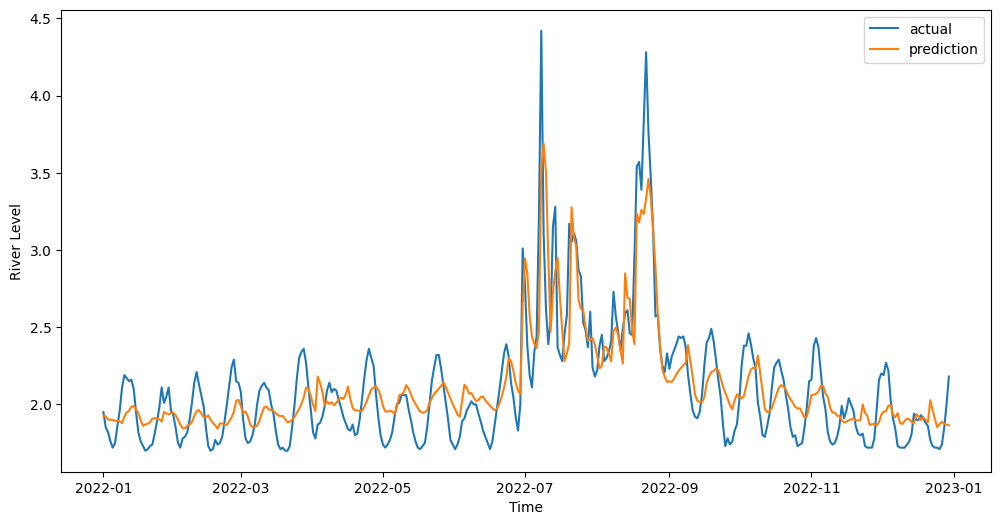

In [28]:
main(3,10)

Epoch 1/10
57/57 [==============================] - 1s 2ms/step - loss: 0.0078
Epoch 2/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 3/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 4/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 5/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 6/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 7/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 8/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 9/10
57/57 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 10/10
12/12 [==============================] - 0s 869us/step
Test MSE: 0.054
NSE: 0.6643183765396361
RMSE: 0.2331863043268855
Buffer Accuracy: 93.95604395604396% - Buffer: 0.40247532159702193


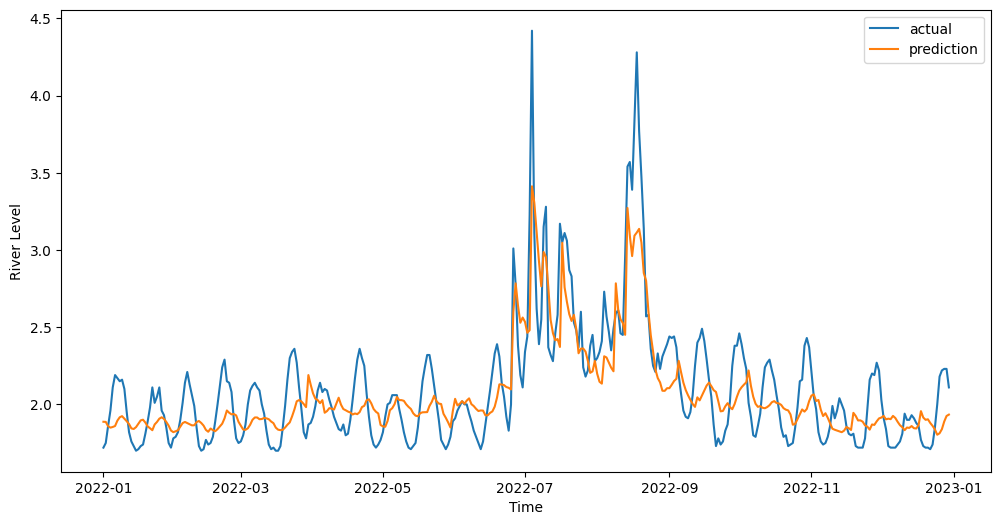

In [29]:
main(7,10)

Epoch 1/10
57/57 [==============================] - 1s 2ms/step - loss: 0.0062
Epoch 2/10
57/57 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 3/10
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 4/10
57/57 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 5/10
57/57 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 6/10
57/57 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 7/10
57/57 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 8/10
57/57 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 9/10
57/57 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 10/10
12/12 [==============================] - 0s 924us/step
Test MSE: 0.056
NSE: 0.653384899836329
RMSE: 0.23767482583224928
Buffer Accuracy: 92.03296703296702% - Buffer: 0.40370064658318866


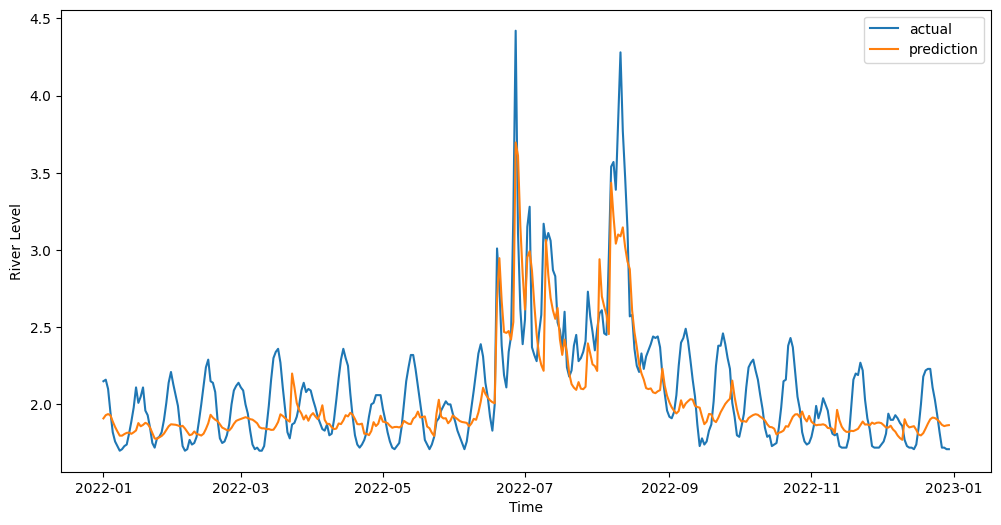

In [30]:
main(14,10)

Epoch 1/30
57/57 [==============================] - 1s 1ms/step - loss: 0.0324
Epoch 2/30
57/57 [==============================] - 0s 984us/step - loss: 0.0079
Epoch 3/30
57/57 [==============================] - 0s 947us/step - loss: 0.0057
Epoch 4/30
57/57 [==============================] - 0s 930us/step - loss: 0.0045
Epoch 5/30
57/57 [==============================] - 0s 915us/step - loss: 0.0038
Epoch 6/30
57/57 [==============================] - 0s 919us/step - loss: 0.0034
Epoch 7/30
57/57 [==============================] - 0s 910us/step - loss: 0.0031
Epoch 8/30
57/57 [==============================] - 0s 955us/step - loss: 0.0029
Epoch 9/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 10/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 11/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 12/30
57/57 [==============================] - 0s 989us/step - loss: 0.0022
Epoch 13/30
57/57 [==============

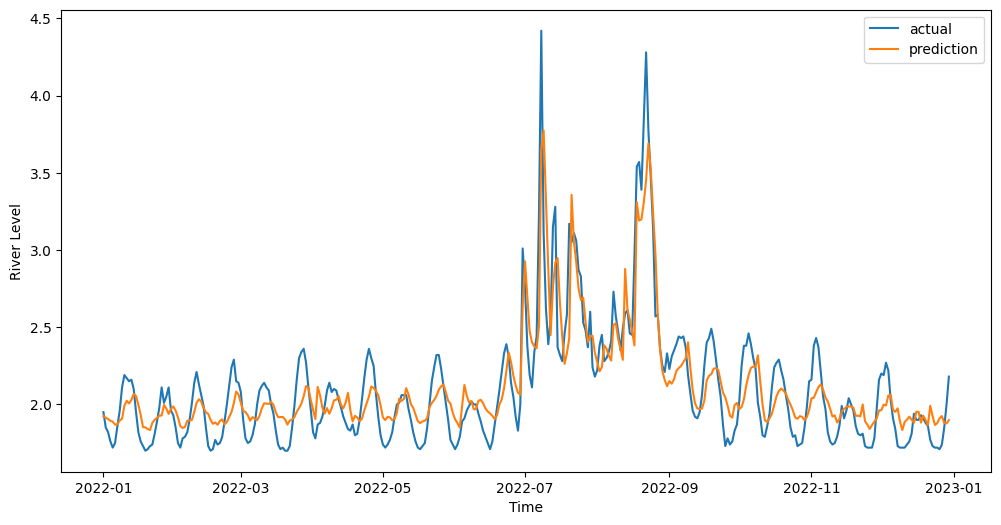

In [31]:
main(3,30)

Epoch 1/30
57/57 [==============================] - 1s 2ms/step - loss: 0.0098
Epoch 2/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 3/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 4/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0046
Epoch 5/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 6/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 7/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 8/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 9/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 10/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 11/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 12/30
57/57 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 13/30
57/57 [==============================

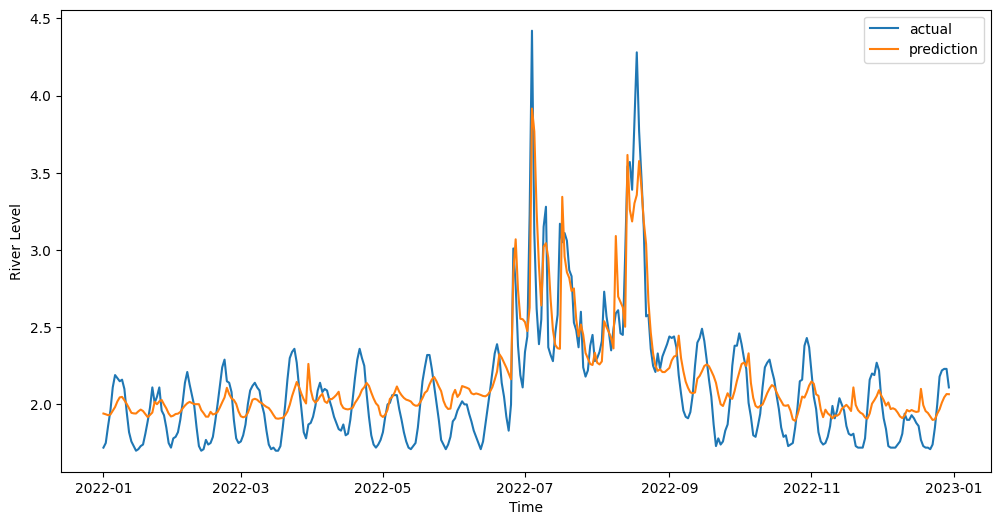

In [32]:
main(7,30)

Epoch 1/30
57/57 [==============================] - 1s 2ms/step - loss: 0.0050
Epoch 2/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 3/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 4/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 5/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 6/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 7/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 9/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 10/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 11/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 12/30
57/57 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 13/30
57/57 [==============================

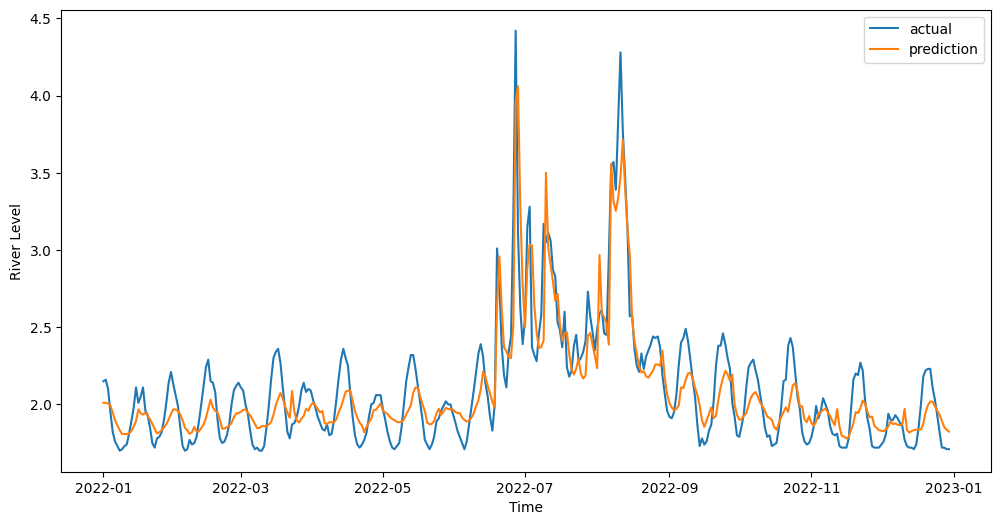

In [33]:
main(14,30)

Epoch 1/50
57/57 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 2/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 3/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 4/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 5/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 6/50
57/57 [==============================] - 0s 998us/step - loss: 0.0027
Epoch 7/50
57/57 [==============================] - 0s 939us/step - loss: 0.0023
Epoch 8/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 9/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 10/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 11/50
57/57 [==============================] - 0s 943us/step - loss: 0.0018
Epoch 12/50
57/57 [==============================] - 0s 968us/step - loss: 0.0018
Epoch 13/50
57/57 [======================

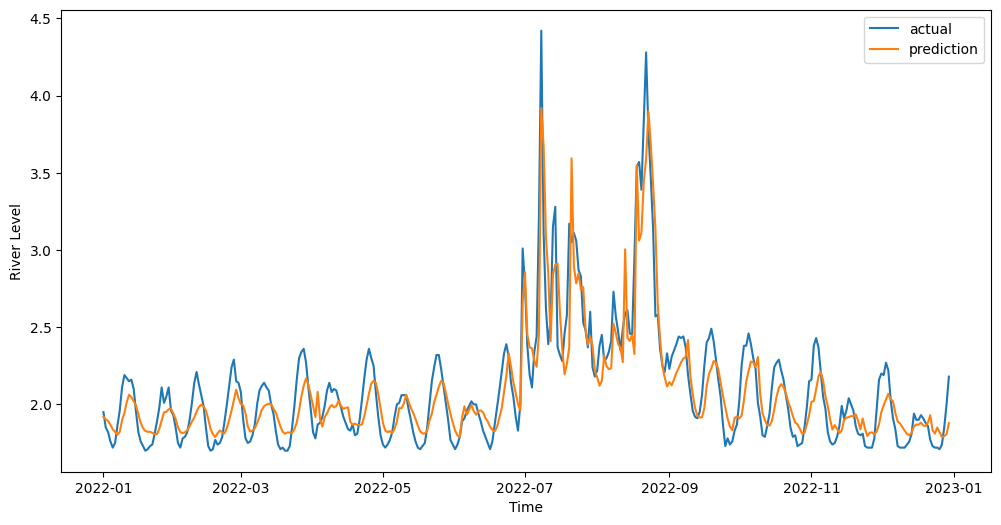

In [34]:
main(3,50)

Epoch 1/50
57/57 [==============================] - 1s 2ms/step - loss: 0.0222
Epoch 2/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 3/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 4/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 5/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 6/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 7/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 8/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 9/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 10/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 11/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 12/50
57/57 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 13/50
57/57 [==============================

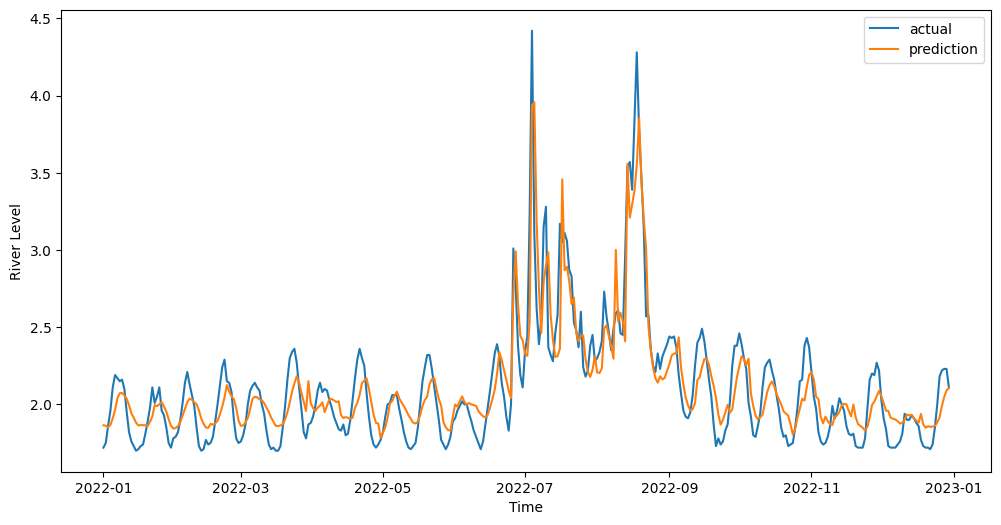

In [35]:
main(7,50)

Epoch 1/50
57/57 [==============================] - 1s 2ms/step - loss: 0.0101
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 4/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 5/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 6/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 7/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 8/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 9/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 10/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 11/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 12/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 13/50
57/57 [==============================

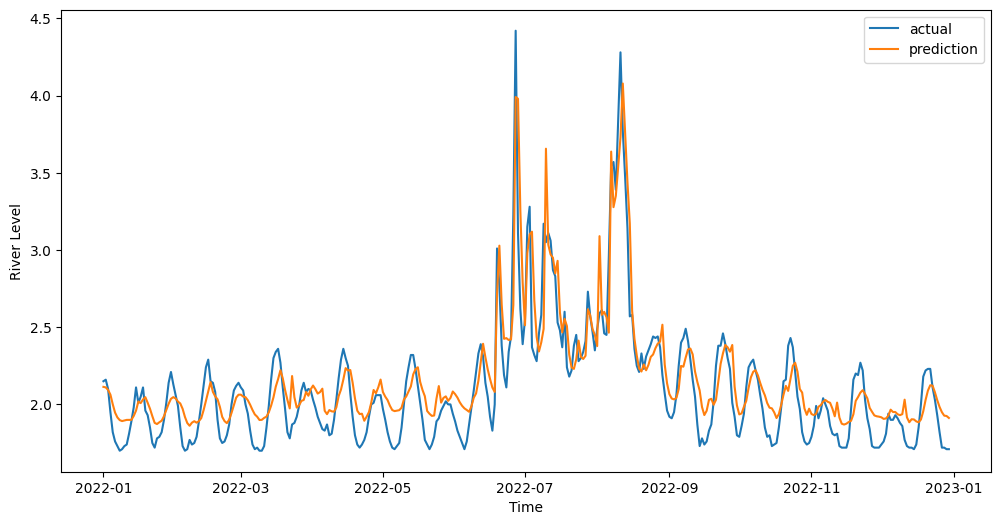

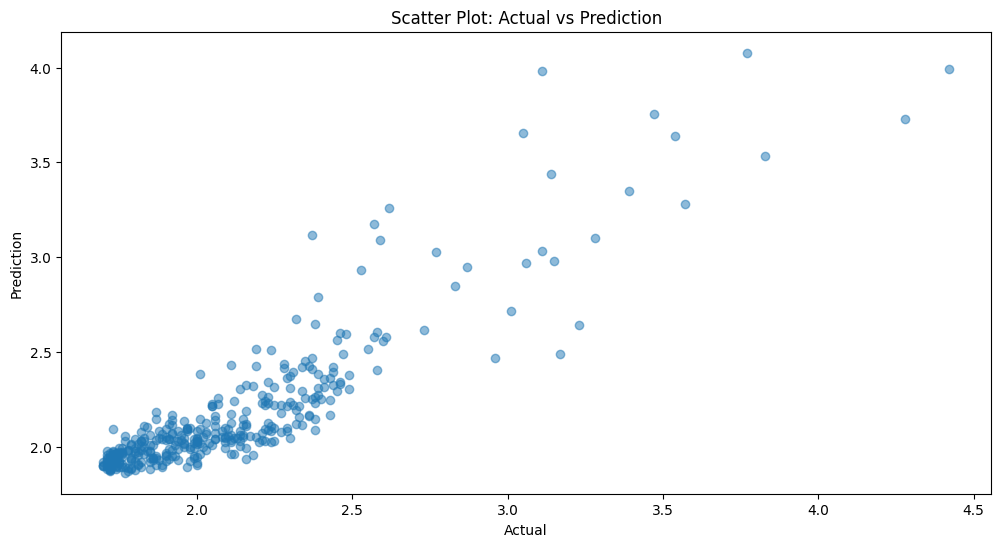

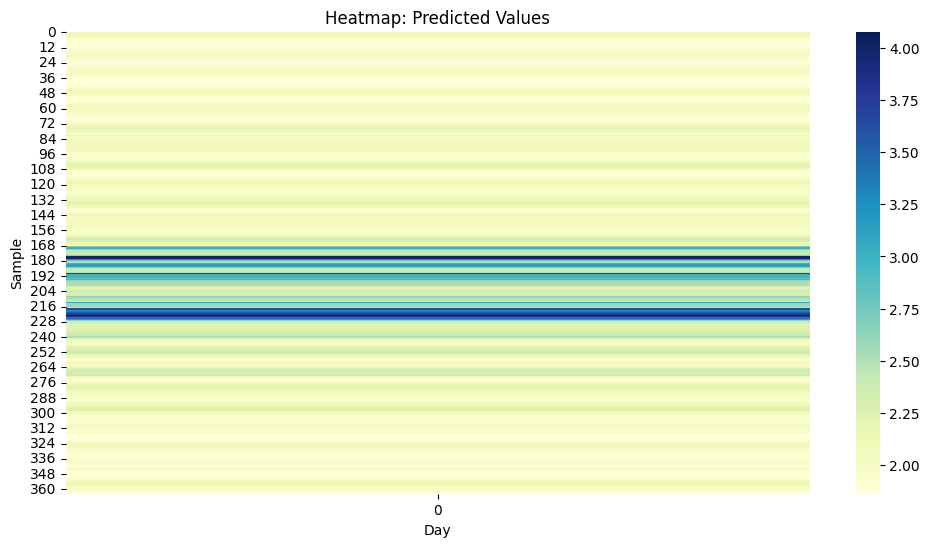

<Figure size 1200x600 with 0 Axes>

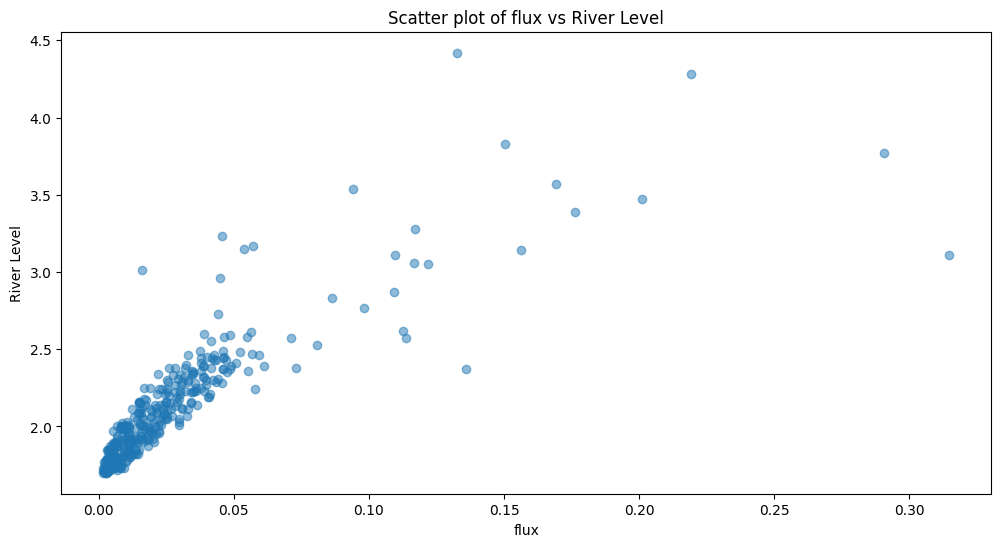

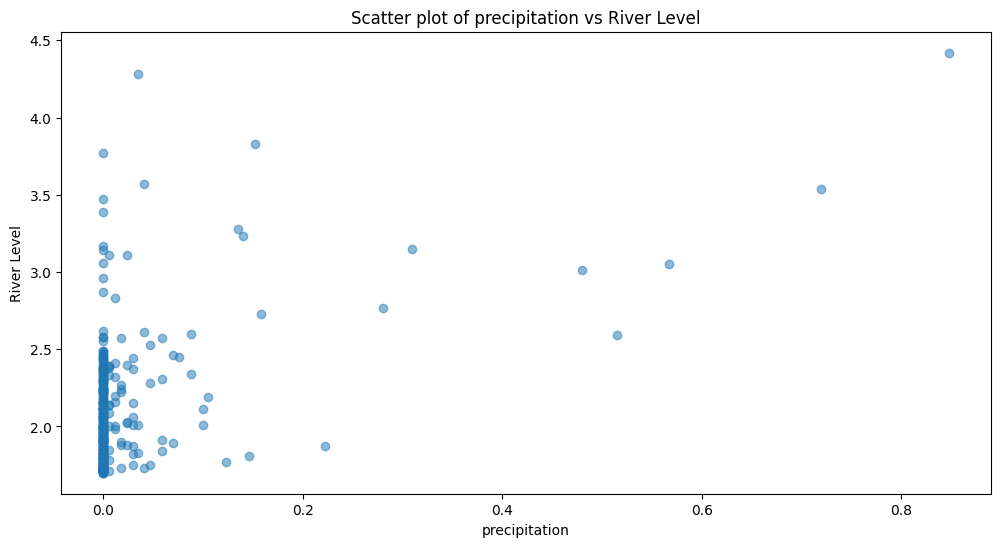

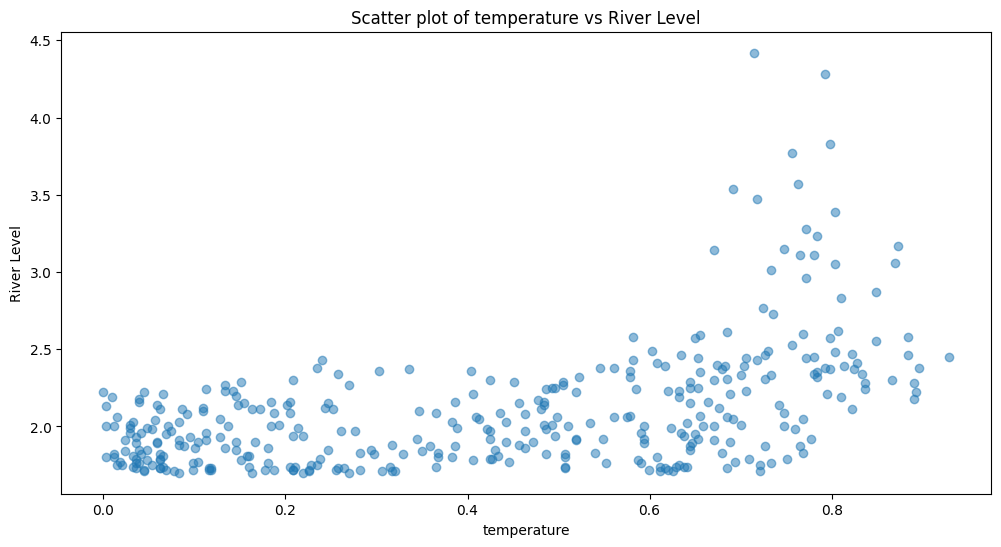

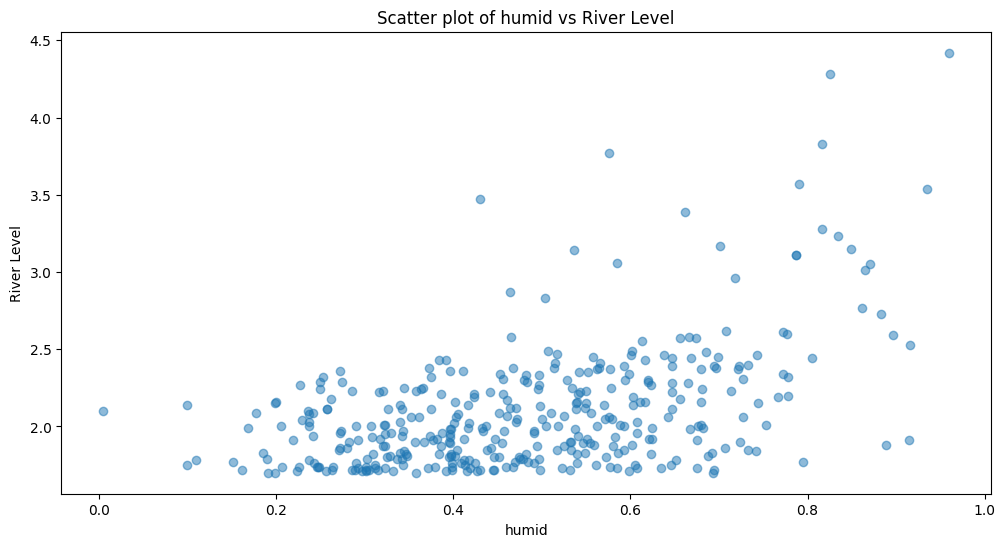

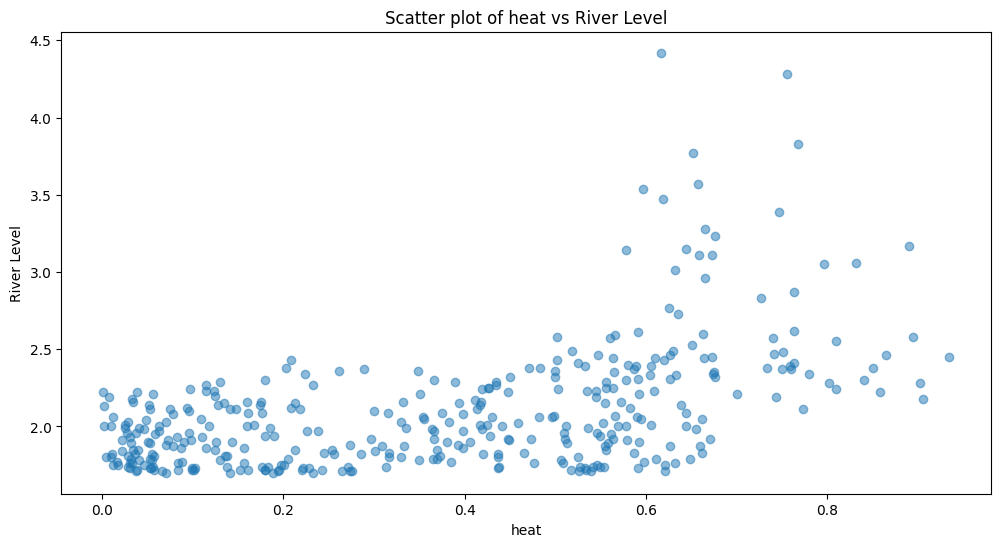

In [39]:
main(14,50, show=True)